In [1]:
## Import packages

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [3]:
## Read in text file as csv

In [4]:
# Read in data, skip metadata
df = pd.read_csv('sadata.txt', sep='\t', comment='!', header=0, skiprows=42) 
# Check data structure
df.head() 

,ID_REF,IDENTIFIER,GSM90867,GSM90868,GSM90869,GSM90870,GSM90871,GSM90872
0,244901_at,orf25,6.65400,7.05434,6.80613,6.82925,7.02770,7.34429
1,244902_at,nad4L,5.28858,6.66294,6.26774,5.78153,6.03939,6.84894
2,244903_at,ArthMp059,6.40003,7.27573,7.28997,6.68200,7.00093,7.48229
3,244904_at,ArthMp060,6.08998,6.44187,6.63831,5.96996,6.63343,6.73362
4,244905_at,ArthMp061,6.18786,6.27292,6.51737,6.59901,6.20906,6.41522


In [5]:
## Check for missing values in dataset

In [6]:
df.isnull().sum()  

ID_REF        0
IDENTIFIER    0
GSM90867      0
GSM90868      0
GSM90869      0
GSM90870      0
GSM90871      0
GSM90872      0
dtype: int64

In [7]:
## Rename columns to more appropriate terms, i.e., controls and treated samples
## Remove ID Ref column, only require one gene identifier for analysis
## Set gene ID as index

In [8]:
# Rename columns to control/treatment samples defined in metadata
df = df.rename(columns={
    'GSM90867': 'Control (1)',
    'GSM90868': 'Control (2)',
    'GSM90869': 'Control (3)',
    'GSM90870': 'Treatment (1)',
    'GSM90871': 'Treatment (2)',
    'GSM90872': 'Treatment (3)',
    'IDENTIFIER' : 'ID',
})
# Drop 'ID_REF' column
df = df.drop(columns=['ID_REF'])

# Set the 'ID' column as the index 
df = df.set_index('ID')

# Verify changes
df.head()

,Control (1),Control (2),Control (3),Treatment (1),Treatment (2),Treatment (3)
ID,,,,,,
orf25,6.65400,7.05434,6.80613,6.82925,7.02770,7.34429
nad4L,5.28858,6.66294,6.26774,5.78153,6.03939,6.84894
ArthMp059,6.40003,7.27573,7.28997,6.68200,7.00093,7.48229
ArthMp060,6.08998,6.44187,6.63831,5.96996,6.63343,6.73362
ArthMp061,6.18786,6.27292,6.51737,6.59901,6.20906,6.41522


In [9]:
## Make average expression columns for control and treatment groups 

In [10]:
# Create a list of column names that contain the word 'Control'
control_columns = [col for col in df.columns if 'Control' in col]

# Create a list of column names that contain the word 'Treatment'
treatment_columns = [col for col in df.columns if 'Treatment' in col]

# Calculate and assign the mean value of control columns to 'Control Avg.'
df['Control Avg.'] = df[control_columns].mean(axis=1)

# Calculate and assign the mean value of treatment columns to 'Treatment Avg.'
df['Treatment Avg.'] = df[treatment_columns].mean(axis=1)

# Verify changes
df.head()

,Control (1),Control (2),Control (3),Treatment (1),Treatment (2),Treatment (3),Control Avg.,Treatment Avg.
ID,,,,,,,,
orf25,6.65400,7.05434,6.80613,6.82925,7.02770,7.34429,6.838157,7.067080
nad4L,5.28858,6.66294,6.26774,5.78153,6.03939,6.84894,6.073087,6.223287
ArthMp059,6.40003,7.27573,7.28997,6.68200,7.00093,7.48229,6.988577,7.055073
ArthMp060,6.08998,6.44187,6.63831,5.96996,6.63343,6.73362,6.390053,6.445670
ArthMp061,6.18786,6.27292,6.51737,6.59901,6.20906,6.41522,6.326050,6.407763


In [11]:
## Make dataset of only average expressions

In [12]:
# Define average expression columns to select
select_average = ["Control Avg.", "Treatment Avg."]

# Create a new DataFrame of only 'Control Avg.' and 'Treatment Avg.'
df_averages = df[select_average]

# Verify the selected columns
print(df_averages.columns)

Index(['Control Avg.', 'Treatment Avg.'], dtype='object')


In [13]:
## Variance Thresholding:
## Select genes which show most variance between control and treatment group averages

In [14]:
## Testing different thresholds to see how many genes vary expression ranging from 0.01 to 3

In [15]:
# Transpose the dataframe so that genes become columns and samples become rows
if df_averages.shape[0] > df_averages.shape[1]:
    df_averages = df_averages.T  # Transpose the dataframe

# Extract expression values into an array
expression_data = df_averages.values  # The numeric data (gene expression values)

# Extract the gene identifiers into a variable
gene_identifiers = df_averages.columns  # Gene names, which are now the columns

# Apply VarianceThreshold to filter genes based on their variance
for threshold in [0, 0.005, 0.01, 0.1, 1, 2, 3]:

    # Create a VarianceThreshold selector object with the current threshold
    selector = VarianceThreshold(threshold=threshold) 
    
    # Apply the selector to the expression data, filter genes based on the threshold
    df_filtered = selector.fit_transform(expression_data)
    
    # Print the threshold used and the number of genes exceeding variance threshold
    print(f"Threshold: {threshold}, Genes with sufficient variance: {df_filtered.shape[1]}")


Threshold: 0, Genes with sufficient variance: 22810
Threshold: 0.005, Genes with sufficient variance: 11043
Threshold: 0.01, Genes with sufficient variance: 8527
Threshold: 0.1, Genes with sufficient variance: 2046
Threshold: 1, Genes with sufficient variance: 70
Threshold: 2, Genes with sufficient variance: 19
Threshold: 3, Genes with sufficient variance: 7


In [16]:
## Applying the selected variance threshold to identify genes with the highest variation
## Aim is to highlight the top ~20 genes which could be useful for further exploration

In [17]:
# Apply VarianceThreshold with threshold of 2, 19 genes appropriate for further study
threshold = 2  # Set variance threshold to 2
selector = VarianceThreshold(threshold=threshold)  # Initialise VarianceThreshold selector
df_filtered = selector.fit_transform(expression_data)  # Apply selector to the data

# Get the selected genes corresponding to the highest variance
selected_genes = gene_identifiers[selector.get_support()]  # Get genes that exceed the variance threshold

# Filter df_averages to keep only selected genes
df_filtered_genes = df_averages[selected_genes]  # Create a new dataframe with only selected genes

# Results output
print(f"Variance Threshold: {threshold}")  # Print the threshold value
print(f"Number of Genes Selected: {len(selected_genes)}")  # Print the number of selected genes
print(f"Selected Genes: {', '.join(selected_genes)}")  # Print the names of selected genes

Variance Threshold: 2
Number of Genes Selected: 19
Selected Genes: ARD3, AT5G51830, WRKY38, CYP81D8, LHT7, WRKY18, AT4G22530, AT4G10500, AT4G01870, AT3G11340, AT3G28510, WRKY54, AT1G08050, NIMIN1, GRX480, GSTU24, UGT75B1, AT1G03850, PR1


In [18]:
## Generating a heatmap for the data after applying the variance threshold
# Create a heatmap highlighting the variance across all individual treatments

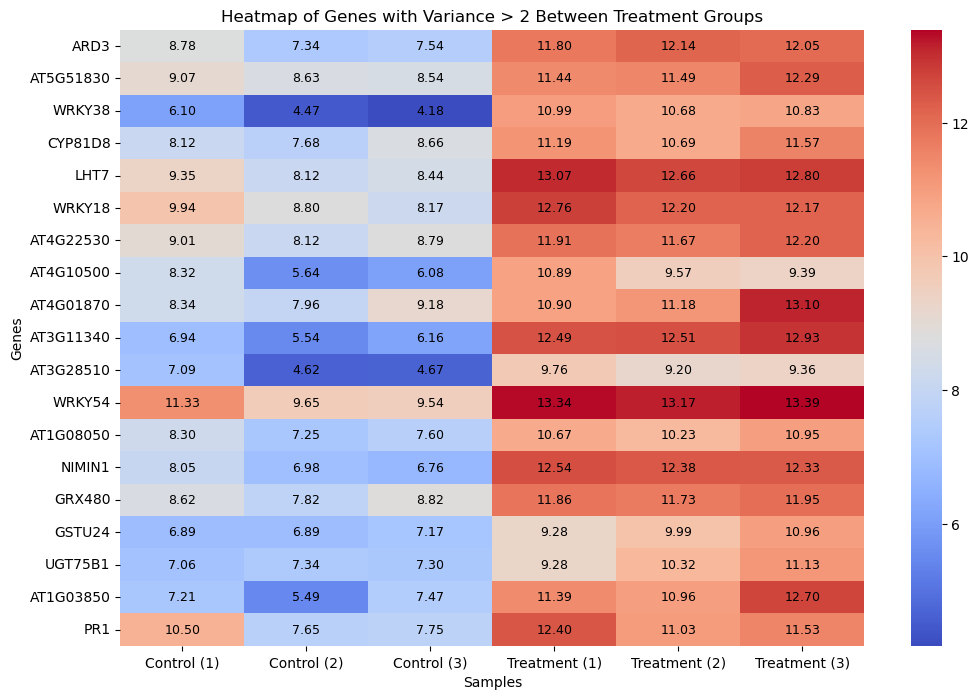

In [19]:
# Include only expression of selected genes across control and treatment columns
df_filtered_genes = df.loc[selected_genes, control_columns + treatment_columns]

# Create a figure
plt.figure(figsize=(12, 8))

# Generate heatmap with the filtered data
sns.heatmap(df_filtered_genes, cmap='coolwarm', annot=True, fmt=".2f", cbar=True, xticklabels=True,
            yticklabels=True, annot_kws={'size': 9, 'color': 'black'})

# Set the title
plt.title(f"Heatmap of Genes with Variance > {threshold} Between Treatment Groups")

# Label the x-axis as 'Samples'
plt.xlabel('Samples')

# Label the y-axis as 'Genes'
plt.ylabel('Genes')

# Display heatmap
plt.show()

In [20]:
## Hierarchical Clustering of Genes - Identifying Genes with Similar Expression Patterns
## Shorter branches indicate more similar expression patterns
## Helpful for future exploration of potential functional relationships among genes

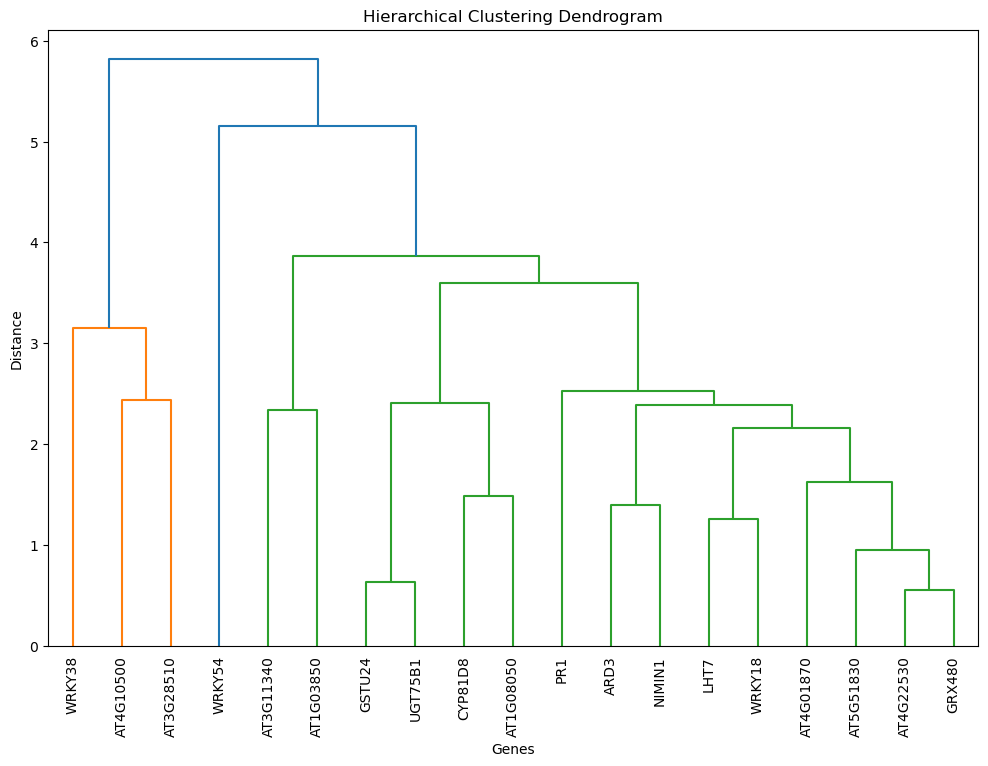

In [21]:
# Distance matrix
# Use 'euclidean' as distance metric and 'average' for linkage method.
distance_matrix = pdist(df_filtered_genes.values, metric='euclidean')  # Calculate pairwise distances between genes
linkage_matrix = linkage(distance_matrix, method='average')  # Hierarchical clustering with average linkage

# Create dendrogram using gene names as labels
plt.figure(figsize=(12, 8)) 
dendrogram(linkage_matrix, labels=df_filtered_genes.index,  
    leaf_rotation=90,  
    leaf_font_size=10,  
    )
#Label and display dendogram plot
plt.title("Hierarchical Clustering Dendrogram")  
plt.xlabel("Genes")  
plt.ylabel("Distance")  
plt.show()  

In [22]:
## PCA - Visualising Group Clustering Using Principal Components

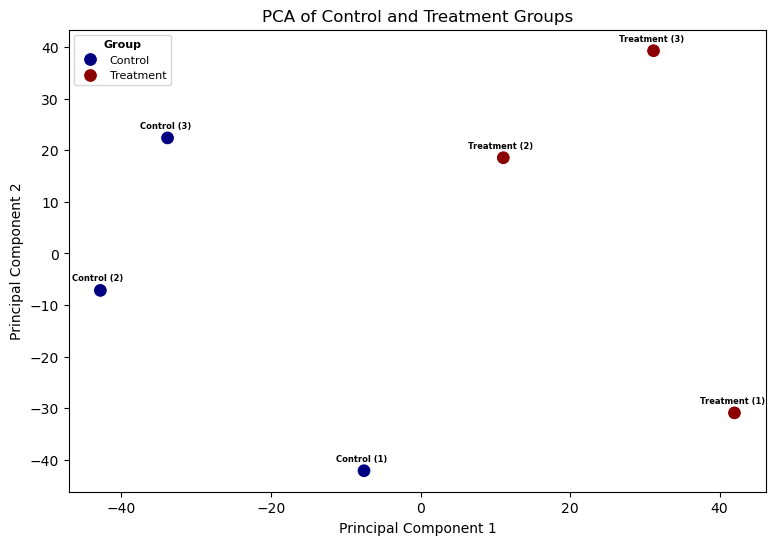

Explained variance ratio:
PC1: 0.4073 (40.73%)
PC2: 0.3573 (35.73%)

Cumulative explained variance:
PC1: 0.4073 (40.73%)
PC2: 0.7646 (76.46%)

Summary:
The principal components explain 76.46% of variance in the data.


In [23]:
# Transpose the DataFrame to make samples rows and genes columns
transposed_df = df.iloc[:, :-2].T  # Exclude average columns 
transposed_df.columns = df.index  # Use gene ID as column names

# Perform PCA 
pca = PCA(n_components=2)  
pca_components = pca.fit_transform(transposed_df)  

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])  
pca_df['Sample'] = transposed_df.index 

# Add "Group" column to label samples as 'Control' or 'Treatment'
pca_df['Group'] = pca_df['Sample'].apply(lambda x: 'Control' if 'Control' in x else 'Treatment')

# Visualize and customise PCA result output
plt.figure(figsize=(9, 6)) 
sns.scatterplot(
    x='PC1', y='PC2',  
    hue='Group',  
    data=pca_df, palette=['navy', 'darkred'], s=100  
)

# Add labels to points and adjust positioning
for i in range(pca_df.shape[0]): 
    plt.text(
        x=pca_df['PC1'][i] - 0.3, 
        y=pca_df['PC2'][i] + 1.5,  
        s=pca_df['Sample'][i],  
        fontdict=dict(color='black', size=6, fontweight='bold'),  
        ha='center',  
        va='bottom'  
    )

# Label and display plot appearance
plt.title('PCA of Control and Treatment Groups')  
plt.xlabel('Principal Component 1')  
plt.ylabel('Principal Component 2')  
legend = plt.legend(title='Group', title_fontsize='8', fontsize='8') 
legend.get_title().set_fontweight('bold')
plt.show()  

# Explained variance ratio - how much variance each component accounts for
explained_variance = pca.explained_variance_ratio_ 
# Calculate cumulative variance
cumulative_variance = np.cumsum(explained_variance) 

# Display explained variance 
print("Explained variance ratio:")
for i, var in enumerate(explained_variance, 1): 
    print(f"PC{i}: {var:.4f} ({var * 100:.2f}%)")  

# Display cumulative explained variance
print("\nCumulative explained variance:")
for i, var in enumerate(cumulative_variance, 1):  
    print(f"PC{i}: {cumulative_variance[i-1]:.4f} ({cumulative_variance[i-1] * 100:.2f}%)")

# Show how much variance two components explain
print("\nSummary:")
print(f"The principal components explain {cumulative_variance[1] * 100:.2f}% of variance in the data.")

In [24]:
## Building Models to Predict Treatment Status of Genes Based on Expression Values

In [25]:
## Already used variance thresholding to select genes that vary the most between control and treatment.
## Is it possible to use machine learning to predict whether genes are upregulated or downregulated based on their control expression alone.
## i.e., does lower/higher expression in a control group make a gene less/more likely to be upregulated when treated?

In [26]:
## To evaluate the models accuracy we first need to observe the distribution of upregulated:downregulated genes

In [27]:
# Total number of genes
total_genes = len(df)

# Count upregulated and downregulated genes
upregulated_genes = (df['Treatment Avg.'] > df['Control Avg.']).sum()
downregulated_genes = (df['Treatment Avg.'] < df['Control Avg.']).sum()

# Calculate percentages
upregulated_percent = (upregulated_genes / total_genes) * 100
downregulated_percent = (downregulated_genes / total_genes) * 100

# Print results
print(f"Number of upregulated genes: {upregulated_genes} ({upregulated_percent:.2f}%)")
print(f"Number of downregulated genes: {downregulated_genes} ({downregulated_percent:.2f}%)")

Number of upregulated genes: 10823 (47.45%)
Number of downregulated genes: 11987 (52.55%)


In [28]:
## Logistic regression modelling

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.65      0.64      2413
           1       0.59      0.57      0.58      2149

    accuracy                           0.61      4562
   macro avg       0.61      0.61      0.61      4562
weighted avg       0.61      0.61      0.61      4562

Accuracy: 0.6139850942569048


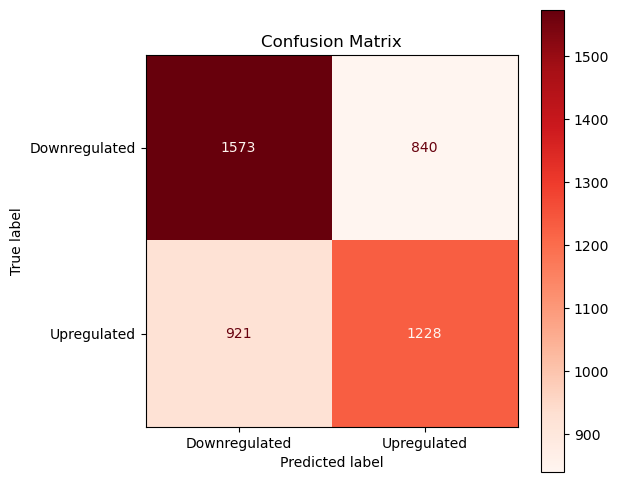

In [29]:
# Label columns
control_columns = ['Control (1)', 'Control (2)', 'Control (3)']
treatment_columns = ['Treatment (1)', 'Treatment (2)', 'Treatment (3)']

# Calculate Log(FC) for each gene
df['logFC'] = np.log(df[treatment_columns].mean(axis=1) / df[control_columns].mean(axis=1))

# Create target column where 1 = upregulated and 0 = downregulated
df['upregulated'] = (df['logFC'] > 0).astype(int)  # 1 if upregulated, 0 if downregulated

# Prepare control data as features and target upregulation (1) and downregulation (0) as target variable 
X = df[control_columns]  
y = df['upregulated']    

# Split data into training and testing groups (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model 
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
print("Classification Report:\n", classification_report(y_test, y_pred))

# Print model accuracy
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)


# Make predictions 
y_pred = model.predict(X_test)  

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Downregulated", "Upregulated"])

# Plot confusion matrix
plt.figure(figsize=(6, 6))
disp.plot(cmap="Reds", ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

In [30]:
## Logistic regression model accuracy is ~61%, performing slightly better than random chance.  
## Lacks confidence in reliably predicting whether a gene is upregulated or downregulated.

In [31]:
## Testing a neural network model to explore whether a more complex model could improve accuracy

Accuracy: 0.6234107847435335


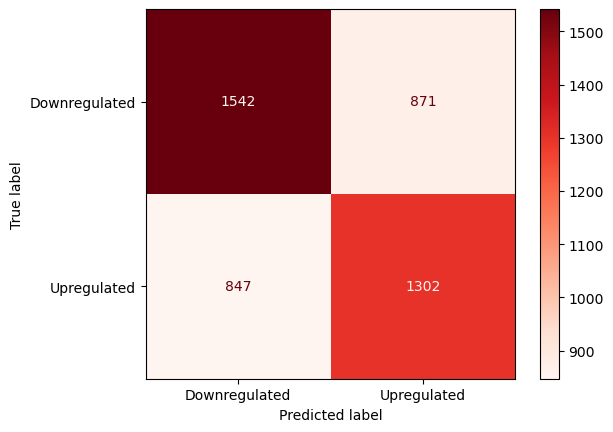

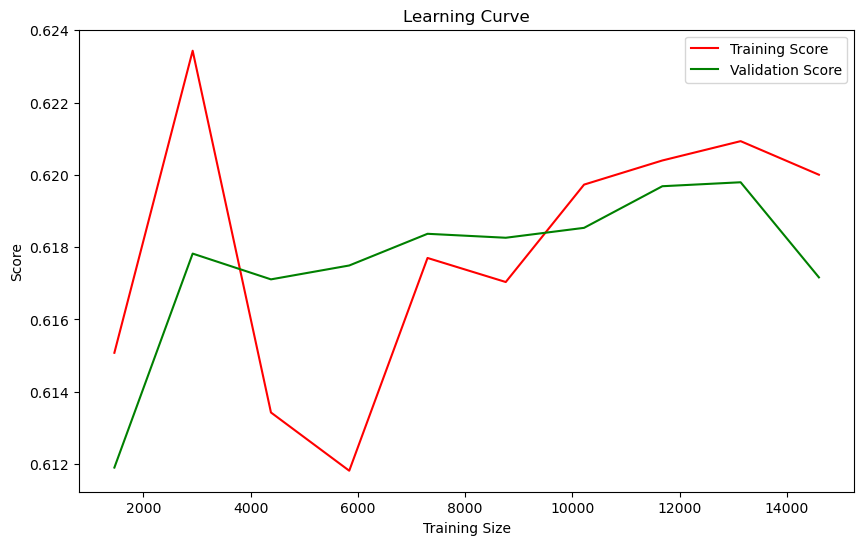

In [32]:
# Select Control data and Treatment data
control_cols = ['Control (1)', 'Control (2)', 'Control (3)']
treatment_cols = ['Treatment (1)', 'Treatment (2)', 'Treatment (3)']
average_cols = ['Control Avg.', 'Treatment Avg.']

# Create a new column to represent upregulation (1 = upregulated, -1 = downregulated)
df['Regulation'] = np.where(df['Treatment Avg.'] > df['Control Avg.'], 1, -1)

# Prepare control data as features (X) and upregulation or downregulation as target variable (y)
X = df[control_cols]  
y = df['Regulation']  

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creating and training the neural network model
model = MLPClassifier(hidden_layer_sizes=(10, 5), max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Downregulated', 'Upregulated'])
disp.plot(cmap='Reds')

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    model, X_train_scaled, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean scores
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="red")
plt.plot(train_sizes, val_mean, label="Validation Score", color="green")
plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Score")
plt.legend()
plt.show()

In [33]:
## Neural network accuracy is ~62%, a small improvement over logistic regression but still only slightly better than random guessing.